In [26]:
from wilds import get_dataset
from wilds.common.data_loaders import get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import numpy as np

from erm_helpers import val_step, build_metrics_dict
from Classifier import Classifier
from SubsampledDataset import SubsampledDataset, NUM_CLASSES


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
BATCH_SIZE = 16

cuda


In [2]:
dataset = get_dataset(dataset="fmow", download=False)
grouper = CombinatorialGrouper(dataset, ["region"])


ood_val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

id_val_data = dataset.get_subset(
    "id_val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

ood_val_dataset = SubsampledDataset(ood_val_data, grouper)
id_val_dataset = SubsampledDataset(id_val_data, grouper)

ood_val_loader   = get_eval_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader    = get_eval_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)

In [4]:
torch.save(ood_val_dataset, 'subsampled_data/ood_val_dataset.pth')
torch.save(id_val_dataset, 'subsampled_data/id_val_dataset.pth')

In [6]:
dataset = get_dataset(dataset="fmow", download=False)

ood_val_dataset = torch.load('subsampled_data/ood_val_dataset.pth')
id_val_dataset = torch.load('subsampled_data/id_val_dataset.pth')

ood_val_loader   = get_eval_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader    = get_eval_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)

In [4]:
def eval_model(model, loss_fn):
  # ood val
  y_true, y_pred, metadata, loss = val_step(model, ood_val_loader, loss_fn, device)
  ood_metrics_dict = build_metrics_dict(dataset, y_true, y_pred, metadata, loss)

  # id val
  y_true, y_pred, metadata, loss = val_step(model, id_val_loader, loss_fn, device)
  id_metrics_dict = build_metrics_dict(dataset, y_true, y_pred, metadata, loss)
  
  return ood_metrics_dict, id_metrics_dict

In [7]:
results = []

model = torch.load("models/ERM_10_15_SGD_0.0001_0.9_CrossEntropy.pth").to(device)
results.append((
  'ERM',
  eval_model(model, loss_fn=torch.nn.CrossEntropyLoss())
))

model = torch.load("models/ERM_10_15_SGD_0.0001_0.9_CrossEntropy_unet_frozen.pth").to(device)
results.append((
  'ERM with frozen pretrained Unet',
  eval_model(model, loss_fn=torch.nn.CrossEntropyLoss())
))

model = torch.load("models/IRM_10_30_SGD_0.0001_0.9_CrossEntropy.pth").to(device)
results.append((
  'IRM',
  eval_model(model, loss_fn=torch.nn.CrossEntropyLoss())
))

model = torch.load("models/IRM_10_30_SGD_0.0001_0.9_CrossEntropy_unet_frozen.pth").to(device)
results.append((
  'IRM with frozen pretrained Unet',
  eval_model(model, loss_fn=torch.nn.CrossEntropyLoss())
))

100%|██████████| 209/209 [00:17<00:00, 11.91it/s]


In [8]:
for name, metrics in results:
  print(name)
  print('ood validation')
  print(', '.join([f'{key} - {value:.8f}' for (key, value) in metrics[0].items()]))
  print('id validation')
  print(', '.join([f'{key} - {value:.8f}' for (key, value) in metrics[1].items()]))
  print()

ERM
ood validation
acc_region:Europe - 0.59820282, acc_region:Americas - 0.49238202, loss - 1.40786018
id validation
acc_region:Europe - 0.52923834, acc_region:Americas - 0.55657494, loss - 1.40919449

ERM with frozen pretrained Unet
ood validation
acc_region:Europe - 0.51668805, acc_region:Americas - 0.38907468, loss - 1.52543815
id validation
acc_region:Europe - 0.43194103, acc_region:Americas - 0.41284403, loss - 1.61892450

IRM
ood validation
acc_region:Europe - 0.55712450, acc_region:Americas - 0.42920849, loss - 1.52021113
id validation
acc_region:Europe - 0.47518426, acc_region:Americas - 0.47247708, loss - 1.58496735

IRM with frozen pretrained Unet
ood validation
acc_region:Europe - 0.49005136, acc_region:Americas - 0.31363806, loss - 1.70733761
id validation
acc_region:Europe - 0.36805898, acc_region:Americas - 0.35779816, loss - 1.83268237



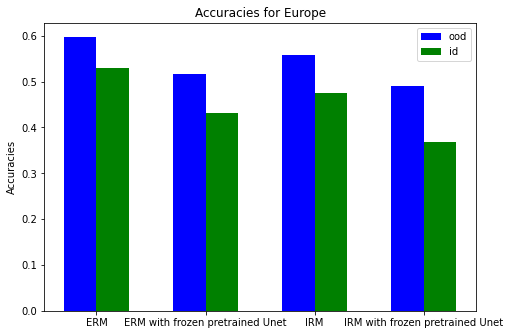

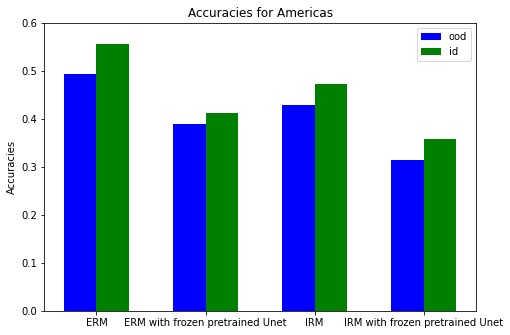

In [49]:
europe_accuracies = np.array([[x[1][i]['acc_region:Europe'] for i in range(2)] for x in results]).T
americas_accuracies = np.array([[x[1][i]['acc_region:Americas'] for i in range(2)] for x in results]).T

X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.15, europe_accuracies[0], color = 'b', width = 0.3)
ax.bar(X + 0.15, europe_accuracies[1], color = 'g', width = 0.3)
ax.set_ylabel('Accuracies')
ax.set_title('Accuracies for Europe')
ax.set_xticks(X, [x[0] for x in results])
ax.set_yticks(np.arange(0, 0.61, 0.1))
ax.legend(labels=['ood', 'id'])
plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.15, americas_accuracies[0], color = 'b', width = 0.3)
ax.bar(X + 0.15, americas_accuracies[1], color = 'g', width = 0.3)
ax.set_ylabel('Accuracies')
ax.set_title('Accuracies for Americas')
ax.set_xticks(X, [x[0] for x in results])
ax.set_yticks(np.arange(0, 0.61, 0.1))
ax.legend(labels=['ood', 'id'])
plt.show()
